In [1]:
import torch
from torch.autograd import Variable
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

root = "/home/xy/桌面/Code/data/"


# -----------------ready the dataset--------------------------
def default_loader(path):
    return Image.open(path).convert('L')
    
class MyDataset (Dataset):
    # 构造函数带有默认参数
    def __init__(self, txt, transform=None, target_transform=None, loader=default_loader):
        fh = open(txt, 'r')
        imgs = []
        i = 0
        for line in fh:
            # 移除字符串首尾的换行符
            # 删除末尾空
            # 以空格为分隔符 将字符串分成
            line = line.strip('\n')
            line = line.rstrip()
            words = line.split()
            imgs.append((words[0], int(words[1])))#imgs中包含有图像路径和标签
        self.imgs = imgs
        self.transform = transform
        self.target_transform = target_transform
        self.loader = loader

    def __getitem__(self, index):
        fn, label = self.imgs[index]
        #调用定义的loader方法
        img = self.loader(fn)
        if self.transform is not None:
            img = self.transform(img)
        return img, label

    def __len__(self):
        return len(self.imgs)


train_data = MyDataset(txt=root + 'traindatalabels.txt', transform=transforms.ToTensor())
test_data = MyDataset(txt=root + 'testdatalabels.txt', transform=transforms.ToTensor())


#train_data 和test_data包含多有的训练与测试数据，调用DataLoader批量加载
trainloader = DataLoader(dataset=train_data, batch_size=4, shuffle=True)
testloader = DataLoader(dataset=test_data, batch_size=4)

torch.Size([4, 1, 50, 50])
tensor([[[0.7608, 0.7529, 0.7529,  ..., 0.6196, 0.6353, 0.6353],
         [0.7451, 0.7412, 0.7451,  ..., 0.6275, 0.6314, 0.6314],
         [0.7333, 0.7333, 0.7412,  ..., 0.6314, 0.6235, 0.6235],
         ...,
         [0.8667, 0.8667, 0.8588,  ..., 0.1569, 0.1725, 0.1765],
         [0.8510, 0.8588, 0.8706,  ..., 0.1765, 0.1686, 0.1686],
         [0.8392, 0.8510, 0.8627,  ..., 0.1686, 0.1294, 0.1294]]])


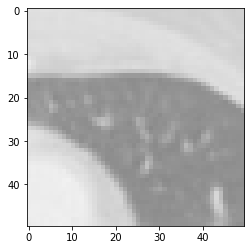

In [2]:
import torchvision
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

def imshow(img):
    img = img / 2 + 0.5     # 还原,标准化逆过程
    #转化为np
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


classes=('阳性','阴性')    
    
# 随机获取训练图片
dataiter = iter(trainloader)
# 获得图片及对应标签
images, labels = dataiter.next()
# 1张图片，灰度图片单通道，大小50*50
print(images.size())
#输出第一张
print(images[0])
imshow(torchvision.utils.make_grid(images[0]))
# 显示所有图片
# imshow(torchvision.utils.make_grid(images))
# 显示数据
# print(' '.join('%8s' % classes[labels[j]] for j in range(4)))


In [3]:
# 建立模型
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #卷积->池化->卷积
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        
        # 全连接层
        self.fc1 = nn.Linear(16 * 9 * 9, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, x):
        #激活函数relu
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        # 展平
        x = x.view(-1, 16 * 9 * 9)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [4]:
import torch.optim as optim
# 交叉熵损失函数
criterion = nn.CrossEntropyLoss()
# SGD优化
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [5]:
#选择gpu
device = torch.device("cuda:0")
net.to(device)
print("start")

X=[]
Y=[]

for epoch in range(10):  # 训练次数

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        
        inputs, labels = data
        #送入gpu
        inputs, labels = inputs.to(device), labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 200 == 199:    # print every 200 mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 200))
            running_loss = 0.0
        
            
            
print('Finished Training')
plt.plot(X,Y)
plt.show()

RuntimeError: cuda runtime error (100) : no CUDA-capable device is detected at /pytorch/aten/src/THC/THCGeneral.cpp:50

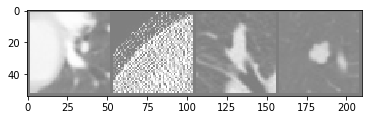

GroundTruth:     阳性    阳性    阳性    阴性


In [10]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# 输出图片
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [11]:
images, labels = images.to(device), labels.to(device)
outputs = net(images)
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

Predicted:     阳性    阳性    阳性    阴性


In [12]:
correct = 0
total = 0
i = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))


Accuracy of the network on the 10000 test images: 88 %


In [17]:
torch.save(net, 'net.pkl')
torch.save(net.state_dict(),'net_para.pkl')